In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

In [2]:
# Папки с расположением файлов датасета
PATH = r'C:\Users\ivan\YandexDisk\DS\Project_13.CV'
image_dir = 'final_files'

In [7]:
pd.read_csv(os.path.join(PATH, 'labels.csv'))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [13]:
def load_data(path, image_dir):
    # Загружаем метки в переменную 
    df_labels = pd.read_csv( os.path.join(path , 'labels.csv'))
    image_path = os.path.join(path, image_dir)
    
    datagen = ImageDataGenerator(rescale = 1./255 , validation_split=0.25)


    # Обучающая выборка
    train_datagen_flow = datagen.flow_from_dataframe(dataframe=df_labels, directory=image_path, 
                                              x_col="file_name", y_col="real_age", has_ext=True, 
                                              class_mode="other", target_size=(200, 200), 
                                              batch_size=16 , seed = 12 , subset = "training")
    
    # Валидационная выборка
    valid_datagen_flow = datagen.flow_from_dataframe(dataframe=df_labels, directory=image_path, 
                                              x_col="file_name", y_col="real_age", has_ext=True, 
                                              class_mode="other", target_size=(200, 200), 
                                              batch_size=16, seed=12 , subset = "validation")
    
    features_train, target_train = next(train_datagen_flow)
    features_valid, target_valid = next(valid_datagen_flow)
   
    # Возвращаем словарь с признаками
    return {'features_train':features_train , 'target_train': target_train, 
           'features_valid': features_valid , 'target_valid': target_valid}

In [14]:
# Печать фотографий
def foto_print(features , foto_num):
    fig = plt.figure(figsize=(10,10))
    for i in range(foto_num):
        fig.add_subplot(4, 4, i+1)
        plt.imshow(features[i])
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

In [15]:
res = load_data(PATH ,image_dir)
feat_train = res['features_train']
targ_train = res['target_train']

Found 5694 validated image filenames.
Found 1897 validated image filenames.


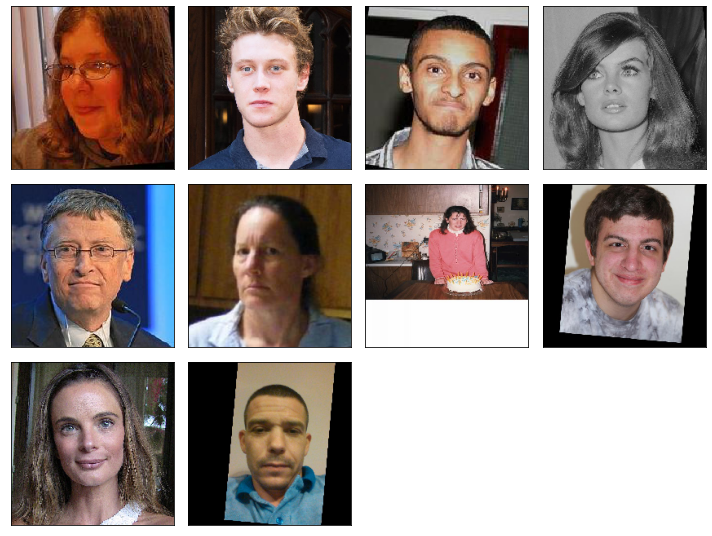

In [17]:
foto_print(feat_train,10)

In [9]:
def load_train(path):    
    df_labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.,
                                  
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  
                                  horizontal_flip = True
                                      )

    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=df_labels, directory=(path+'final_files/'), 
                                              x_col="file_name", y_col="real_age", has_ext=True, 
                                              class_mode="other", target_size=(200, 200), 
                                              batch_size=16 , seed = 12 , subset = "training")
    
   
    

    return train_datagen_flow


In [10]:
def load_test(path):    
    df_labels = pd.read_csv(path + 'labels.csv')
    
    valid_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)


    valid_datagen_flow = valid_datagen.flow_from_dataframe(dataframe=df_labels, directory=(path + 'final_files/'), 
                                              x_col="file_name", y_col="real_age", has_ext=True, 
                                              class_mode="other", target_size=(200, 200), 
                                              batch_size=16, seed=12 , subset = "validation")
   
    
    
    return valid_datagen_flow

In [11]:
def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = 24, activation = 'relu'))


    model.add(Dense(units = 1, activation = 'relu'))


    model.compile(optimizer=optimizer, loss='mse',
                  metrics=[MeanAbsoluteError()])

    return model

In [12]:
def train_model(model, train_data, test_data, batch_size=None, epochs=3,
               steps_per_epoch=None, validation_steps=None):

    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
   
    
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
